In [1]:
!pip install tushare
import tushare as ts
ts.set_token('61116a06e6984550a29e763cdd76ec0606d37aee4fe74f91a8d36b32')
pro=ts.pro_api('61116a06e6984550a29e763cdd76ec0606d37aee4fe74f91a8d36b32')
import os

In [2]:
import os
import pandas as pd
filename = 'e:/stockdata/bigfile.csv'
for code in ['002271', '600703', '002415','002557','000725','600048','601601','002230','002044','002475']:
    df = ts.get_hist_data(code)
    df.to_csv('e:/stockdata/'+code+'.csv')

In [3]:
stockdic={'东方雨虹':'002271', '三安光电':'600703', '海康威视':'002415','洽洽食品':'002557','京东方A':'000725',
          '保利地产':'600048','中国太保':'601601','科大讯飞':'002230','美年健康':'002044','立讯精密':'002475'}

In [4]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --upgrade mplfinance

from pandas import DataFrame, Series
import pandas as pd; import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.dates import MonthLocator,MONTHLY
import datetime as dt
import pylab

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Found existing installation: mplfinance 0.12.3a3
    Uninstalling mplfinance-0.12.3a3:
      Successfully uninstalled mplfinance-0.12.3a3


D:\Anaconda\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [5]:
daylinefilespath ='e:/stockdata/'
stock_b_code =stockdic['东方雨虹']
MA1 = 11
MA2 = 51
startdate = dt.date(2016, 6, 29)
enddate = dt.date(2017, 1, 30)

def readstkData(rootpath, stockcode, sday, eday):
    
    returndata = pd.DataFrame()
    for yearnum in range(0,int((eday - sday).days / 365.25)+1):
        theyear = sday + dt.timedelta(days = yearnum * 365)
        # build file name
        #filename = rootpath  + theyear.strftime('%Y') + '\\' + str(stockcode).zfill(6) + '.csv'
        filename=rootpath+stockcode+'.csv'
        print(filename)
        
        try:
            rawdata = pd.read_csv(filename, parse_dates = True, index_col = 0, encoding = 'gbk')
        except IOError:
           raise Exception('IoError when reading dayline data file: ' + filename)

        returndata = pd.concat([rawdata, returndata])
    
    # Wash data
    returndata = returndata.sort_index()
    returndata.index.name = 'DateTime'
    #returndata.drop('amount', axis=1, inplace = True)
    returndata.columns = ['Open', 'High', 'Close', 'Low', 'Volume','price_change','p_change','ma5','ma10','ma20','v_ma5','v_ma10','v_ma20'
]

    #returndata = returndata[returndata.index < eday.strftime('%Y-%m-%d')]

    return returndata

def movingaverage1(a,WSZ):
  # a:原始数据，NumPy 1-D array containing the data to be smoothed
  # 必须是1-D的，如果不是，请使用 np.ravel()或者np.squeeze()转化 
  # WSZ: smoothing window size needs, which must be odd number,
  # as in the original MATLAB implementation
    print(np.ones(WSZ,dtype=int))
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate(( start , out0, stop ))

def movingaverage(data, window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return ma_vec

In [6]:
def calculateEMA(period, closeArray, emaArray=[]):
    """计算指数移动平均"""
    length = len(closeArray)
    nanCounter = np.count_nonzero(np.isnan(closeArray))
    if not emaArray:
        emaArray.extend(np.tile([np.nan],(nanCounter + period - 1)))
        firstema = np.mean(closeArray[nanCounter:nanCounter + period - 1])    
        emaArray.append(firstema)    
        for i in range(nanCounter+period,length):
            ema=(2*closeArray[i]+(period-1)*emaArray[-1])/(period+1)
            emaArray.append(ema)        
    return np.array(emaArray)
    
def calculateMACD(closeArray,shortPeriod = 12 ,longPeriod = 26 ,signalPeriod =9):
    ema12 = calculateEMA(shortPeriod ,closeArray,[])
    ema26 = calculateEMA(longPeriod ,closeArray,[])
    diff = ema12-ema26
    dea= calculateEMA(signalPeriod ,diff,[])
    macd = 2*(diff-dea)
    return macd,diff,dea 

e:/stockdata/002271.csv


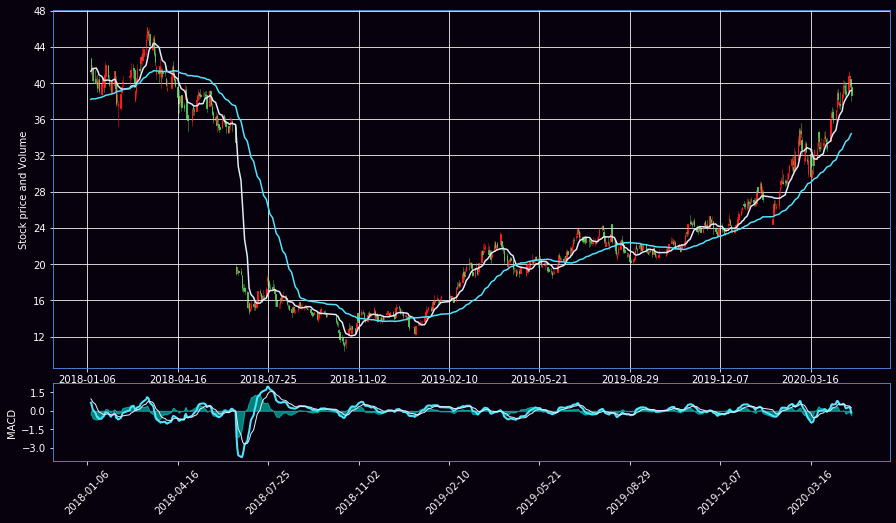

In [7]:
def main():
    days = readstkData(daylinefilespath, stock_b_code, startdate, enddate)
    #print(days)
    # drop the date index from the dateframe & make a copy
    daysreshape = days.reset_index()
    # convert the datetime64 column in the dataframe to 'float days'
    #daysreshape['DateTime']=mdates.date2num(daysreshape['DateTime'].astype(dt.datetime))
    daysreshape['DateTime']=mdates.date2num(daysreshape['DateTime'].dt.to_pydatetime())
    # clean day data for candle view 
    daysreshape.drop('Volume', axis=1, inplace = True)
    daysreshape = daysreshape.reindex(columns=['DateTime','Open','High','Low','Close'])  
    
    Av1 = movingaverage(daysreshape.Close.values, MA1)
    Av2 = movingaverage(daysreshape.Close.values, MA2)
    SP = len(daysreshape.DateTime.values[MA2-1:])
    fig = plt.figure(facecolor='#07000d',figsize=(15,10))
    
    ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)#, axisbg='#07000d')
    candlestick_ohlc(ax1, daysreshape.values[-SP:], width=.6, colorup='#ff1717', colordown='#53c156')
    Label1 = str(MA1)+' SMA'
    Label2 = str(MA2)+' SMA'
    
    ax1.plot(daysreshape.DateTime.values[-SP:],Av1[-SP:],'#e1edf9',label=Label1, linewidth=1.5)
    ax1.plot(daysreshape.DateTime.values[-SP:],Av2[-SP:],'#4ee6fd',label=Label2, linewidth=1.5)
    ax1.grid(True, color='w')
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.yaxis.label.set_color("w")
    ax1.spines['bottom'].set_color("#5998ff")
    ax1.spines['top'].set_color("#5998ff")
    ax1.spines['left'].set_color("#5998ff")
    ax1.spines['right'].set_color("#5998ff")
    ax1.tick_params(axis='y', colors='w')
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    ax1.tick_params(axis='x', colors='w')
    #plt.rcParams['axes.facecolor'] = ''
    ax1.patch.set_facecolor("#07000d")
    plt.ylabel('Stock price and Volume')
    
    ax2 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4)#, axisbg='#07000d')
    fillcolor = '#00ffe8'
    nslow = 26
    nfast = 12
    nema = 9
    macd,emaslow, emafast = calculateMACD(daysreshape.Close.values)
    ema9 = calculateEMA(nema,macd)
    ax2.plot(daysreshape.DateTime.values[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
    ax2.plot(daysreshape.DateTime.values[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
    ax2.fill_between(daysreshape.DateTime.values[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    ax2.spines['bottom'].set_color("#5998ff")
    ax2.spines['top'].set_color("#5998ff")
    ax2.spines['left'].set_color("#5998ff")
    ax2.spines['right'].set_color("#5998ff")
    ax2.tick_params(axis='x', colors='w')
    ax2.tick_params(axis='y', colors='w')
    plt.ylabel('MACD', color='w')
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
    ax2.patch.set_facecolor("#07000d")
    for label in ax2.xaxis.get_ticklabels():
        label.set_rotation(45)   
    plt.show()

if __name__ == "__main__":
    main()

In [15]:
    ax2 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, axisbg='#07000d')
    fillcolor = '#00ffe8'
    nslow = 26
    nfast = 12
    nema = 9
    emaslow, emafast, macd = computeMACD(daysreshape.Close.values)
    ema9 = ExpMovingAverage(macd, nema)
    ax2.plot(daysreshape.DateTime.values[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
    ax2.plot(daysreshape.DateTime.values[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
    ax2.fill_between(daysreshape.DateTime.values[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)
     plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    ax2.spines['bottom'].set_color("#5998ff")
    ax2.spines['top'].set_color("#5998ff")
    ax2.spines['left'].set_color("#5998ff")
    ax2.spines['right'].set_color("#5998ff")
    ax2.tick_params(axis='x', colors='w')
    ax2.tick_params(axis='y', colors='w')
    plt.ylabel('MACD', color='w')
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
    for label in ax2.xaxis.get_ticklabels():
        label.set_rotation(45)   

,exchange,cal_date,is_open,pretrade_date
0,SSE,20180901,0,20180831
1,SSE,20180902,0,20180831
2,SSE,20180908,0,20180907
3,SSE,20180909,0,20180907
4,SSE,20180915,0,20180914
5,SSE,20180916,0,20180914
6,SSE,20180922,0,20180921
7,SSE,20180923,0,20180921
8,SSE,20180924,0,20180921
9,SSE,20180929,0,20180928
